# 라이브러리 설치 및 데이터 준비

## 라이브러리 설치

In [ ]:
!pip install rdkit-pypi
!pip install lifelines
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dgllife
!pip install PyTDC

     |████████████████████████████████| 22.7 MB 72.1 MB/s 
     |████████████████████████████████| 349 kB 4.8 MB/s 
     |████████████████████████████████| 68 kB 8.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=ffe856bef68a849743a832e9ee35529bc6e1501607afaf31d4e6d2511cf82bca
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in links: https://data.dgl.ai/w

     |████████████████████████████████| 138 kB 4.8 MB/s 
  Created wheel for dgllife: filename=dgllife-0.2.9-py3-none-any.whl size=219056 sha256=88cc6f82f57894c51562ce330530b208f1081a0e4851c63f161012786fd1fe5c
  Stored in directory: /root/.cache/pip/wheels/34/83/11/9772c74b559d9182c9083362e8ba8b0201c4963e41e03859fe
Successfully built dgllife
     |████████████████████████████████| 88 kB 4.1 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.6-py3-none-any.whl size=120882 sha256=cdfb39a54ff4fc247a4960ac81f9c34bfa88c5b19f17380fb9900888c659fe27
  Stored in directory: /root/.cache/pip/wheels/c3/54/29/38349b4cf57cda21a1493f61721a6d72b232061f7665102d47
Successfully built PyTDC


## Therapeutics Data Commons API로 데이터 불러오기

![](https://drive.google.com/uc?export=view&id=1EmX9QhqQCJK04VtqWfqigqIFaUd1sUPR)


### Toxicity Prediction Task Overview
https://tdcommons.ai/single_pred_tasks/tox/




---


**Definition**: Majority of the drugs have some extents of toxicity to the human organisms. This learning task aims to predict accurately various types of toxicity of a drug molecule towards human organisms.

**Impact**: Toxicity is one of the primary causes of compound attrition. Study shows that approximately 70% of all toxicity-related attrition occurs preclinically (i.e., in cells, animals) while they are strongly predictive of toxicities in humans. This suggests that an early but accurate prediction of toxicity can significantly reduce the compound attribution and boost the likelihood of being marketed.

**Generalization**: Similar to the ADME prediction, as the drug structures of interest evolve over time, toxicity prediction requires a model to generalize to a set of novel drugs with small structural similarity to the existing drug set.

**Product**: Small-molecule.

**Pipeline**: Efficacy and safety - lead development and optimization.


Acute Toxicity LD50

---


**Dataset Description**: Acute toxicity LD50 measures the most conservative dose that can lead to lethal adverse effects. The higher the dose, the more lethal of a drug. This dataset is kindly provided by the authors of [1].

**Task Description**: Regression. Given a drug SMILES string, predict its acute toxicity.

**Dataset Statistics**: 7,385 drugs.


**References**:

[1] Zhu, Hao, et al. “Quantitative structure− activity relationship modeling of rat acute toxicity by oral exposure.” Chemical research in toxicology 22.12 (2009): 1913-1921.

**Dataset License**: Not Specified. CC BY 4.0.

In [ ]:
# 학습에 사용할 데이터 불러오기

from tdc.single_pred import Tox

data = Tox(name = 'LD50_Zhu')
split = data.get_split()

Downloading...
100%|██████████| 707k/707k [00:00<00:00, 5.83MiB/s]
Loading...
Done!


In [ ]:
split['train']

,Drug_ID,Drug,Y
0,"Methane, tribromo-",BrC(Br)Br,2.343
1,Bromoethene (9CI),C=CBr,2.330
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
4,"Benzene, bromo-",Brc1ccccc1,1.765
...,...,...,...
5165,"Benzenesulfonic acid, 3,5-dimethyl-4-hydroxy-",Cc1cc(S(=O)(=O)O)cc(C)c1O,1.883
5166,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
5167,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
5168,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


# Dataset 및 DataLoader 만들기

In [ ]:
# Data 나누기

for mode in ['train', 'valid', 'test']:  
  split[mode]['embedding'] = split[mode]['Drug']

### Custom dataset 만들기

In [ ]:
from torch.utils import data
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
import torch
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


https://lifesci.dgl.ai/_modules/dgllife/utils/mol_to_graph.html


smiles_to_bigraph

---


![](https://drive.google.com/uc?export=view&id=1wsldkWCEmz82ILcnTz-ICdc1IwFbe17m)


CanonicalAtomFeaturizer

---
![](https://drive.google.com/uc?export=view&id=1zcD1bB7taipjsKCbZ4eJbGBwR1Vpreze)


CanonicalBondFeaturizer

---

![](https://drive.google.com/uc?export=view&id=1q_th2kL3gz6k11OCqwplzwxo9XH9o67i)


### <참고>
**SMILE string(또는 rdkit mol's object)을 graph object를 바꾸기**  
https://github.com/violet-sto/TGSA/blob/master/smiles2graph.py

In [ ]:
class data_process_loader(data.Dataset):
  def __init__(self, df):
    """SMILE(str) data를 dgl graph로 변환
    Args:
        df: 'embedding'과 'Y' 열을 가지는 Pandas DataFrame 
    """
    self.df = df

    # Atom Featurizer
    self.node_featurizer = CanonicalAtomFeaturizer()

    # Bond Featurizer
    self.edge_featurizer = CanonicalBondFeaturizer(self_loop = True)

    # smiles_to_bigraph에서 add_self_loop가 항상 True인 새로운 함수 생성
    self.fc = partial(smiles_to_bigraph, add_self_loop=True)

  def __len__(self):
    'Sample 수 반환'
    return self.df.shape[0]

  def __getitem__(self, index):
    v_d = self.df.iloc[index]['embedding'] # drug SMILES 
    v_d = self.fc(smiles = v_d, node_featurizer = self.node_featurizer, edge_featurizer = self.edge_featurizer) # SMILES to graph 
    y = self.df.iloc[index]['Y'] # label 

    return v_d, y


In [ ]:
train_dataset = data_process_loader(split["train"])
valid_dataset = data_process_loader(split["valid"])
test_dataset = data_process_loader(split["test"])

In [ ]:
for v_d, y in train_dataset:
  print(v_d)
  print(y)
  break

Graph(num_nodes=4, num_edges=10,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
2.343


In [ ]:
# DGL graph ndata(node feature) 확인

print(v_d.ndata['h'].shape)
v_d.ndata['h']

torch.Size([4, 74])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

In [ ]:
# DGL graph edata(edge feature) 확인

print(v_d.edata['e'].shape)
v_d.edata['e']

torch.Size([10, 13])


tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
# batch size 확인

v_d.batch_size

1

### DataLoader 만들기


**Collate function**

> collate_fn = None (default)

--input 값이 tensors, numpy array, numbers, dicts, lists 이면서 shape이 동일해야 한다.


- 위의 형이 아니면 아래와 같은 오류가 발생
```
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'dgl.heterograph.DGLHeteroGraph'>
```


- batch 간 차원이 맞지 않을 경우 다음과 같은 오류 발생
```
RuntimeError: size mismatch, m1: [a x b], m2: [c x d]
```




*** 따라서 위와 같은 경우에는 collate_function을 직접 정의해서 사용해야 함


---


> collate_fn = custom_collate_fun


* Example 1) input 데이터가 dgl graph 인 경우
```
def custom_collate_fun(x):
	x, y = zip(*x)
	# dgl graph 
	x = dgl.batch(x) # Batch a collection of DGLGraph
	return x, torch.tensor(y)
```

* Example 2) 각 input data 마다 크기가 다른 경우
```
from torch.nn.utils.rnn import pad_sequence
def custom_collate_fun(batch):
	(xx, yy) = zip(*batch)
	x_lens = [len(x) for x in xx]
	y_lens = [len(y) for y in yy]

	xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
	yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

	return xx_pad, yy_pad, x_lens, y_lens
```


In [ ]:
def dgl_collate_func(x): 
	"""DataLoade에 사용되는 collate function 
	dgp graph를 batch collection으로 만들기
	"""	
	x, y = zip(*x)
 
	# dgl graph 
	x = dgl.batch(x) # Batch a collection of DGLGraph
	return x, torch.tensor(y)

In [ ]:
params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False,
        'collate_fn' : dgl_collate_func} # 이건 처음으로 건드는것 dgl library 

In [ ]:
training_generator = data.DataLoader(train_dataset, **params)
valid_generator = data.DataLoader(valid_dataset, **params)
test_generator = data.DataLoader(test_dataset, **params)

In [ ]:
for v_d, y in training_generator:
  print('\n@input(DGL_graph--->')
  print(v_d)
  print(f"batch_size of input: {v_d.batch_size}")

  print('\n@label(toxicity)--->')
  print(y)
  print(f"shape of label: {y.shape}")
  break


@input(DGL_graph--->
Graph(num_nodes=1036, num_edges=3158,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
batch_size of input: 64

@label(toxicity)--->
tensor([3.1770, 1.4080, 1.6150, 1.4550, 2.1000, 1.5870, 4.2200, 4.7920, 3.6870,
        2.0480, 3.3350, 3.8270, 1.8670, 1.9580, 2.1350, 4.6240, 2.1070, 2.6800,
        4.6480, 2.7250, 1.2150, 3.2150, 1.7470, 4.3880, 2.8870, 3.2330, 4.8650,
        1.9220, 2.4120, 2.6620, 1.3410, 1.8560, 1.3710, 2.1340, 2.6260, 1.8610,
        1.7530, 2.4280, 0.6170, 3.5560, 1.7490, 2.4240, 2.3130, 2.1720, 2.7730,
        1.4000, 1.5960, 2.3650, 2.4100, 2.5740, 1.8200, 3.6200, 1.5780, 2.3730,
        2.6350, 1.7550, 3.8600, 4.9290, 2.8150, 2.8820, 2.0460, 3.5150, 1.7180,
        4.8060], dtype=torch.float64)
shape of label: torch.Size([64])


# 모델 학습

### 학습을 위한 세팅

In [ ]:
import torch.nn.functional as F
from torch import nn 
from dgllife.model.gnn.gcn import GCN
from dgllife.model.readout.weighted_sum_and_max import WeightedSumAndMax

In [ ]:
# 디바이스 설정

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 cuda:0 입니다.


### 학습 모델 만들기

In [ ]:
config = {"gnn_hid_dim_drug" : 64,
          "gnn_num_layers" : 3,
          "gnn_activation" : F.relu,
          "hidden_dim_drug" : 256,
          "cls_hidden_dims" : [1024, 1024, 512]}

In [ ]:
# 기존의 gnn 매우 비효율적 

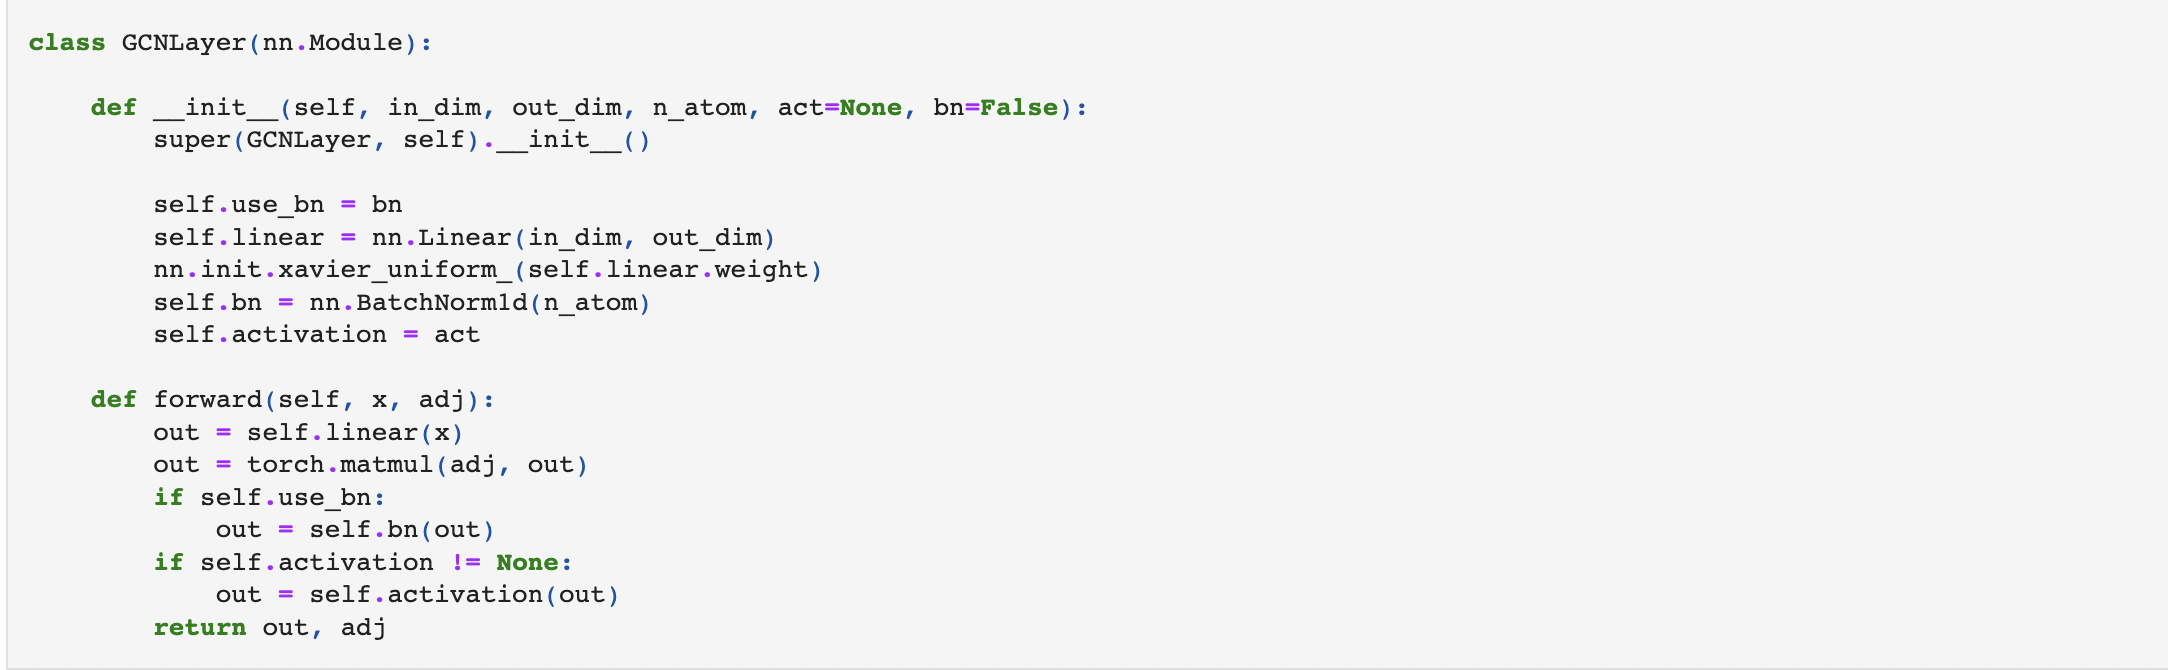

In [ ]:
class DGL_GCN(nn.Module):
	"""Graph embedding을 위한 graph convolution network
	"""
	
	def __init__(self, in_feats, hidden_feats=None, activation=None, predictor_dim=None):
		"""
		Args:
				in_feats: int / input node feature 수 
				hidden_feats: list of int / hidden_feats[i]: i 번째 node representation 크기. len(hidden_feats): GCN layer 개수
				activation: list of activation function / activation[i]: i 번째 activation function. len(activation): GCN layer 개수. (default ReLU)
				predictor_dim: int / 최종 embedding 크기

		"""
		super(DGL_GCN, self).__init__()

		#	graph convolution layer 
		self.gnn = GCN(in_feats=in_feats,
						hidden_feats=hidden_feats,
						activation=activation)

		gnn_out_feats = self.gnn.hidden_feats[-1] # 마지막 GCN layer 이 후 node representation 크기
		self.readout = WeightedSumAndMax(gnn_out_feats) # 마지막 layer 이 후 node feature readout (weighted sum & max pooling)
		self.transform = nn.Linear(gnn_out_feats * 2, predictor_dim) #한번더 mlp layer 돌리기

	def forward(self, bg):
		bg = bg.to(device) # batch of DGL graph
		feats = bg.ndata.pop('h') # (batch, nodes, in_feats) 
		node_feats = self.gnn(bg, feats) # (batch, nodes, gnn_out_feats)
		graph_feats = self.readout(bg, node_feats) # (Batch, gnn_out_feats * 2)
		
		return self.transform(graph_feats) # (Batch, predictor_dim)

In [ ]:
class Classifier(nn.Sequential):
	def __init__(self, model_drug):
		super(Classifier, self).__init__()
	
		# GNN을 이용항 Drug embedding 
		self.model_drug = model_drug

		# mlp layers 쌓기
		self.input_dim_drug = config['hidden_dim_drug']
		self.hidden_dims = config['cls_hidden_dims']

		layer_size = len(self.hidden_dims) + 1
		dims = [self.input_dim_drug] + self.hidden_dims + [1]
		
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

		# droput 확률
		self.dropout = nn.Dropout(0.1)
	
	def forward(self, v_D):
		# drup embedding 
		v_f = self.model_drug(v_D)
		
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				# last layer
				v_f = l(v_f)
			else:
				# hidden layers
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f    

In [ ]:
# drug embedding 모델

model_drug = DGL_GCN(in_feats = 74, 
									hidden_feats = [config['gnn_hid_dim_drug']] * config['gnn_num_layers'], 
									activation = [config['gnn_activation']] * config['gnn_num_layers'], 
									predictor_dim = config['hidden_dim_drug'])

# classifier
model = Classifier(model_drug)

model = model.to(device)

### 학습 진행

In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index


In [ ]:
# hyperparameters 설정 
learning_rate = 0.0001
decay         = 0.00001
max_MSE       = 10000
train_epoch   = 40

# optimizer 
opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)

# 손실 함수
loss_fn = torch.nn.MSELoss()

In [ ]:

loss_history = [] # loss 저장할 list

model_max = copy.deepcopy(model) # 최고 성능 모델 deepcopy

# valid metric 기록
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])

table = PrettyTable(valid_metric_header)
float2str = lambda x:'%0.4f'%x

print('--- Go for Training ---')

### 학습 시작
t_start = time() 

for epo in range(train_epoch):
  
  ## Training
  model.train()

  for i, (v_d, label) in enumerate(training_generator):
    v_d = v_d
    score = model(v_d)
    n = torch.squeeze(score, 1)
    loss = loss_fn(n.float(), label.float().to(device))

    loss_history.append(loss.item())

    # gradient 초기화 -> back-propagation -> parameter update
    opt.zero_grad()
    loss.backward()
    opt.step()
  

  with torch.set_grad_enabled(False):
    y_pred = []
    y_label = []

    ## Validation
    model.eval()  

    for i, (v_d, label) in enumerate(valid_generator):
      v_d = v_d.to(device)
      score = model(v_d)
      logits = torch.squeeze(score, 1).cpu().detach().numpy()
      label_ids = label.to('cpu').numpy()
      y_label = y_label + label_ids.flatten().tolist()
      y_pred = y_pred + logits.flatten().tolist()

  
  ## metric 계산
  # Mean Square Error
  mse = mean_squared_error(y_label, y_pred)
  # Pearson corrleation coefficient 
  r2 = pearsonr(y_label, y_pred)[0] # coefficient
  p_val = pearsonr(y_label, y_pred)[1] # p-value
  # concordace index 
  CI = concordance_index(y_label, y_pred) 

  logits = y_pred

  # metric 저장 
  lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))
  valid_metric_record.append(lst)

  # max MSE, max model update
  if mse < max_MSE:
    model_max = copy.deepcopy(model)
    max_MSE = mse

  print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])
  
  table.add_row(lst)
  


--- Go for Training ---
Validation at Epoch 1 , MSE: 0.83322 , Pearson Correlation: 0.52821 with p-value: 2.90E-54 , Concordance Index: 0.67972
Validation at Epoch 2 , MSE: 0.68994 , Pearson Correlation: 0.60424 with p-value: 1.20E-74 , Concordance Index: 0.70335
Validation at Epoch 3 , MSE: 0.64143 , Pearson Correlation: 0.61906 with p-value: 2.75E-79 , Concordance Index: 0.71174
Validation at Epoch 4 , MSE: 0.60859 , Pearson Correlation: 0.66223 with p-value: 2.46E-94 , Concordance Index: 0.72377
Validation at Epoch 5 , MSE: 0.59904 , Pearson Correlation: 0.65427 with p-value: 2.25E-91 , Concordance Index: 0.72766
Validation at Epoch 6 , MSE: 0.54642 , Pearson Correlation: 0.69444 with p-value: 2.63E-107 , Concordance Index: 0.73750
Validation at Epoch 7 , MSE: 0.52005 , Pearson Correlation: 0.69960 with p-value: 1.52E-109 , Concordance Index: 0.74502
Validation at Epoch 8 , MSE: 0.51515 , Pearson Correlation: 0.70007 with p-value: 9.45E-110 , Concordance Index: 0.74492
Validation at

In [ ]:
#MSE loss 니까 내려가야됨 p value 낮을 수록 좋은것 

# Pearson Correlation


https://lunch-box.tistory.com/94

# C-index 

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=cjh226&logNo=221380929786


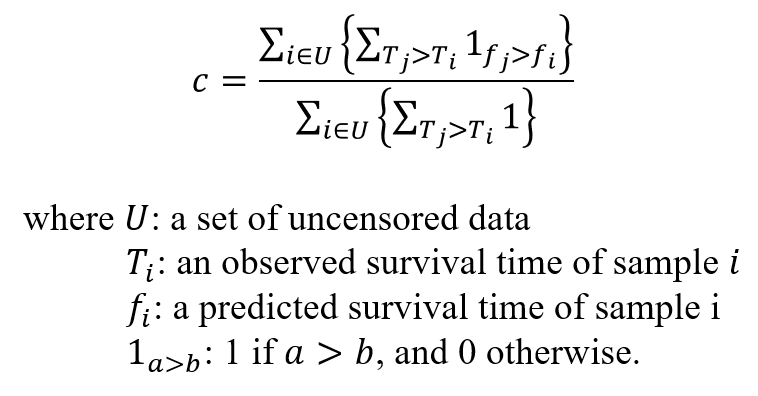

# 모델 테스트

In [ ]:
for i, (v_d, label) in enumerate(test_dataset):
  print(v_d)
  print(label)
  break

Graph(num_nodes=19, num_edges=59,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
3.114


In [ ]:
y_pred = []
y_label = []

model = model_max

model.eval()
for i, (v_d, label) in enumerate(test_generator):
  v_d = v_d.to(device)

  # forward-pass 진행
  score = model(v_d)
  logits = torch.squeeze(score).detach().cpu().numpy()
  
  label_ids = label.to('cpu').numpy()
  y_label = y_label + label_ids.flatten().tolist()
  y_pred = y_pred + logits.flatten().tolist()


In [ ]:
  ## metric 계산

  # Mean Square Error
  mse = mean_squared_error(y_label, y_pred)
  # Pearson corrleation coefficient 
  r2 = pearsonr(y_label, y_pred)[0] # coefficient
  p_val = pearsonr(y_label, y_pred)[1] # p-value
  # concordace index 
  CI = concordance_index(y_label, y_pred) 

print('Test result: ' + 'MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
          + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

Test result: MSE: 0.37885 , Pearson Correlation: 0.77633 with p-value: 6.02E-298 , Concordance Index: 0.77044


### 테스트 결과 시각화

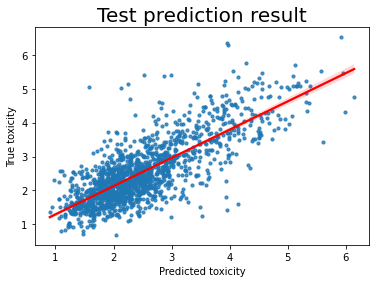

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_pred,
           y=y_label, 
          scatter_kws={'s':10},
          line_kws={"color":"r"},
           fit_reg=True) # default

plt.xlabel('Predicted toxicity')
plt.ylabel('True toxicity')
plt.title('Test prediction result', fontsize=20)

plt.show()


# 수고하셨습니다.

In [ ]:
#